In [1]:
import numpy as np
import pandas as pd

# Step 1: Building List

## Collecting instances from 311 calls, crimes, and blight violations

Data already cleaned by [this notebook](./Cleaning_data.ipynb)
The collection of data was saved at __../data/events.csv__

In [16]:
data_events = pd.read_csv('../data/events.csv')

In [18]:
data_events.sort_values(by='addr',inplace=True)

In [21]:
data_events.head(10)

,event_id,lon,lat,addr,type
2778,2778,-83.041618,42.408738,5949 casmere st,1
919,919,-83.175329,42.358054,8641 littlefield,1
12722,12722,-83.137666,42.338734,wagner,1
372868,372868,-83.216326,42.369786,0 10th,3
372312,372312,-83.216326,42.369786,0 10th,3
345447,345447,-83.216326,42.369786,0 10th,3
372311,372311,-83.216326,42.369786,0 10th,3
372887,372887,-83.216326,42.369786,0 10th,3
345451,345451,-83.216326,42.369786,0 10th,3
377671,377671,-83.216326,42.369786,0 10th,3


In [129]:
events_grouped = data_events.groupby(by=['addr'], axis=0)

In [152]:
events_grouped_list = {'addr': [], 'lon': [], 'lat': [], 'event_id_list': []}

unknown_address = []

epsilon = 1.0e-5 # 1/40 of median length of a building or 1/20 of median width of a building

def similar_vals(lst, epsilon=1.0e-5):
    '''determine if the lst contains almost identical values. If it does, return median value.
    Otherwise return -9999'''
    if len(lst) == 1:
        return lst[0]
    
    avg_val = np.median(lst)
    notSimilar = False
    for val in lst:
        if abs(val-avg_val) > epsilon:
            notSimilar=True
            break
    if notSimilar:
        return -9999
    else:
        return avg_val

In [158]:
for a_group in events_grouped:
    address, entry = a_group
    event_id_list = entry['event_id'].values.tolist()
    lon = entry['lon'].drop_duplicates().values.tolist()
    lat = entry['lat'].drop_duplicates().values.tolist()
    
    if len(lon) == 1:
        lon = lon[0] 
    else:
        effect_lon = similar_vals(lon)
        if effect_lon < -1000:
            unknown_address.append(entry)
            continue
        lon = effect_lon
        
    if (len(lat) == 1):
        lat = lat[0]
    else:
        effect_lat = similar_vals(lat)
        if effect_lat < -1000:
            unknown_address.append(entry)
            continue
        lat = effect_lat
        
        
    if len(events_grouped_list['addr']) != 0:
        # check if previous address is actually the same
        prev_lon = events_grouped_list['lon'][-1]
        prev_lat = events_grouped_list['lat'][-1]
        if (abs(lon-prev_lon) < epsilon) and (abs(lat-prev_lat) < epsilon):
            events_grouped_list['event_id_list'][-1] = events_grouped_list['event_id_list'][-1] \
                                                            + event_id_list
        else:
            events_grouped_list['addr'].append(address)
            events_grouped_list['lon'].append(lon)
            events_grouped_list['lat'].append(lat)
            events_grouped_list['event_id_list'].append(event_id_list)
    else:
        events_grouped_list['addr'].append(address)
        events_grouped_list['lon'].append(lon)
        events_grouped_list['lat'].append(lat)
        events_grouped_list['event_id_list'].append(event_id_list)

    
buildings = pd.DataFrame(events_grouped_list)

In [159]:
len(unknown_address)

0

In [160]:
buildings.shape

(173458, 4)

In [161]:
buildings.head(10)

,addr,event_id_list,lat,lon
0,5949 casmere st,[2778],42.408738,-83.041618
1,8641 littlefield,[919],42.358054,-83.175329
2,wagner,[12722],42.338734,-83.137666
3,0 10th,"[372868, 372312, 345447, 372311, 372887, 34545...",42.369786,-83.216326
4,0 10th st,[440257],42.325449,-83.064139
5,0 11th,"[306426, 378616, 373086]",42.411997,-83.167339
6,0 15th,[307472],42.441234,-83.219551
7,0 18th,[376876],42.341516,-83.087758
8,0 21st,[254794],42.323726,-83.081573
9,0 22nd,[382405],42.330432,-83.088302


## Recap of [step 0](./Building_size_estimation.ipynb)

## Adopting building coordinates
It turns out that there is a slight mismatch between real world building coordinates w.r.t given data. So that only average building dimension info is reserved from the building info we got from online open data at data.detroitmi.gov.

In [172]:
data_dir = '../data/'

In [173]:
buildings_step_0 = pd.read_csv(data_dir+'buildings_step_0.csv')
permits = pd.read_csv(data_dir+'permits.csv')

In [174]:
permits = permits[['PARCEL_NO', 'BLD_PERMIT_TYPE', 'addr', 'lon', 'lat']]

In [175]:
permits['BLD_PERMIT_TYPE'].unique()

array(['Dismantle', 'DISM'], dtype=object)

### For example: the very first entry of permit has coordinate:

In [179]:
lon01 = permits.loc[1200,'lon']
lat01 = permits.loc[1200,'lat']
print(lon01,lat01)

-83.107940092 42.382456019


### In real world data, this corresponds to:

In [177]:
c = buildings_step_0['addr'].apply(lambda x: x == permits.loc[0,'addr'])

In [181]:
buildings_step_0[c][['lon','lat']]

,lon,lat
261994,-82.947708,42.393997


The coordinate of this building from data.detroitmi.gov is different from data given in our course material.

### Only building dimension info is adopted for our analysis.

In [15]:
length = 0.000411
width = 0.000204  # These results come from step 0.

In [182]:
buildings['llcrnrlon'] = buildings['lon'] - length/2
buildings['llcrnrlat'] = buildings['lat'] - width/2
buildings['urcrnrlon'] = buildings['lon'] + length/2
buildings['urcrnrlat'] = buildings['lat'] + width/2

In [189]:
buildings.head()

,addr,event_id_list,lat,lon,llcrnrlon,llcrnrlat,urcrnrlon,urcrnrlat
0,5949 casmere st,[2778],42.408738,-83.041618,-83.041824,42.408636,-83.041412,42.408840
1,8641 littlefield,[919],42.358054,-83.175329,-83.175535,42.357952,-83.175123,42.358156
2,wagner,[12722],42.338734,-83.137666,-83.137871,42.338632,-83.137460,42.338836
3,0 10th,"[372868, 372312, 345447, 372311, 372887, 34545...",42.369786,-83.216326,-83.216532,42.369684,-83.216121,42.369888
4,0 10th st,[440257],42.325449,-83.064139,-83.064345,42.325347,-83.063934,42.325551


In [183]:
buildings.to_csv('../data/buildings.csv', index=False)

### Visualization

In [2]:
from bbox import draw_screen_bbox
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
buildings = pd.read_csv('../data/buildings.csv')
bboxes = buildings.loc[:,['llcrnrlon','llcrnrlat','urcrnrlon','urcrnrlat']]
bboxes = bboxes.as_matrix()

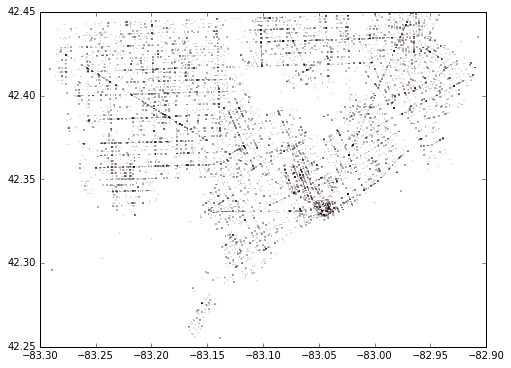

In [5]:
fig = plt.figure(figsize=(8,6))
for box in bboxes[:16000]:     # This is only less than 1/10 of buildings
    draw_screen_bbox(box, fig)
    
plt.xlim(-83.3,-82.9)
plt.ylim(42.25,42.45)
plt.savefig('../data/buildings_distribution.png')
plt.show()